# Markov Decision Processes: Solution by Linear Programming


Linear programming is an __exact__ solution method to a Markov decision process.  It produces the optimal __value function__ $V$, which can then be translated into the optimal policy.


A Markov decision process is defined by:


+ $S$ : a set of states 
+ $A$ : a set of actions 
+ $H$ : a finite time horizon $i=1, ..., H$ 
+ $T$ : $S \times A \times S \times \{1,...,H\} \rightarrow [0,1]$ a transition probability function $P(s_{t+1} = s' | s_t = s, a_t = a)$
+ $R$ : $S \times A \times S \times \{1,...,H\} \rightarrow \mathbb{R}$ a reward function $R(s,a,s')$

+ $\gamma$: a discount factor. 

The desired result is an optimal policy $\pi^{*}: S \times \{0,...,H\} \rightarrow A$ which describes the optimal action $a^{*}$to be undertaken for each state $s$. 

Alternatively, to find $\pi$ such that:

$$ \text{max}_{\pi} E[\sum_{t=0}^{H}\gamma^{t} R(s_{t},a_t,s_{t+1})| \pi]$$

### Linear Programming



The convex optimization problem becomes:



$$
\begin{array}{lc}
\text{minimize} & \sum_{S} V(s) \\
\text{subject to} & V(s) \geq R(s) + \gamma \sum_{s'}T(s,a,s')V(s') \text{ for all } a \in A, s \in S \\
\end{array}
$$
    
   
__NB__: Ref[3] was especially useful stating the LP problem. 



## Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import datetime
import os
from dateutil import relativedelta

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import scipy.stats as stats

import cvxpy as cvx

import warnings
warnings.filterwarnings('ignore')

## Data Transformation Functions

In [2]:
def gridworld_to_T(gridworld,A):
    # Returns the transition probability function
    
    # the set of actions (up, down, left, right)
    # p_intended = P(s_t+1 = s' | a_t is towards s')
    # p_unintended = uniform over all possible remaining target states 
    # nans are walls, boundaries are absolute
    # actions into walls or boundaries will "bounce" into other states with uniform probability
    
    
    
    T = np.zeros(tuple(list(gridworld.shape) + [A.shape[0]] + list(gridworld.shape)) )
    
    p_intended = 0.8
    
    for idx in range(gridworld.shape[0]):
        for jdx in range(gridworld.shape[1]):
            
            possible_actions = [True, True, True, True]
            num_possible_actions = len(possible_actions)
            
            #check for walls here 
            if np.isnan(gridworld[idx][jdx]):
                continue
                
            
            #determine possible actions for position, taking into account sinks and boundaries 
            for adx,action in enumerate(A):
                if not 0<=idx + action[0] < gridworld.shape[0]:
                    possible_actions[adx] = False 
                    num_possible_actions-=1
                    continue
                if not 0<=jdx + action[1] < gridworld.shape[1]:
                    possible_actions[adx] = False 
                    num_possible_actions-=1
                    continue 
                if np.isnan(gridworld[idx+action[0]][jdx+action[1]]):
                    possible_actions[adx] = False 
                    num_possible_actions-=1
                    
            #at this point we have the possible actions 
            #now we must determine if an intended action is possible
            # and how to distribute the probabilities
            
            #outer loop is intended action
            for adx,action in enumerate(A):
                
                #intended action is possible
                if possible_actions[adx]:
                    
                    T[idx][jdx][adx][idx+action[0]][jdx+action[1]] = p_intended
                    
                    #fill in remaining actions
                    for bdx,bction in enumerate(A):
                        if bdx != adx and possible_actions[bdx]:
                            T[idx][jdx][adx][idx+bction[0]][jdx+bction[1]] = \
                            (1.0-p_intended)/(num_possible_actions-1)
                    
                #intended action is not possible, uniform assignment to remaining actions
                elif not possible_actions[adx]:
                    #fill in remaining actions 
                    for bdx,bction in enumerate(A):
                        if bdx != adx and possible_actions[bdx]:
                            T[idx][jdx][adx][idx+bction[0]][jdx+bction[1]] = (1.0)/float((num_possible_actions))   
         
    
                        
    return T

In [3]:
def gridworld_to_R(gridworld,A):
    # Returns the reward function
    
    # the set of actions (up, down, left, right)
    # rewards of target states are taken directly from the gridworld
    # nans/walls remain as zero 
    # Returns the reward function
      
    
    R = np.zeros(tuple(list(gridworld.shape) + [A.shape[0]] + list(gridworld.shape)) )
        
    
    for idx in range(gridworld.shape[0]):
        for jdx in range(gridworld.shape[1]):
            
            possible_actions = [True, True, True, True]
            
            #determine possible actions for position, taking into account walls and boundaries 
            for adx,action in enumerate(A):
                if not 0<=idx + action[0] < gridworld.shape[0]:
                    possible_actions[adx] = False 
                    continue
                if not 0<=jdx + action[1] < gridworld.shape[1]:
                    possible_actions[adx] = False 
                    continue 
                if np.isnan(gridworld[idx+action[0]][jdx+action[1]]):
                    possible_actions[adx] = False 
                    
            #at this point we have the possible actions 
            #now we must determine if an intended action is possible
            # and assign the rewards
            
            #outer loop is intended action
            for adx,action in enumerate(A):
                
                #intended action is possible
                if possible_actions[adx]:
                    R[idx][jdx][adx][idx+action[0]][jdx+action[1]] = gridworld[idx+action[0]][jdx+action[1]]
       
    return R
    

## Data

In [4]:
gridworld = np.zeros((9,9))   #rewards are floats, walls/sinks are nans, boundaries are absolute
gridworld[0][8] = 10 
gridworld[8][8] = 10 
gridworld[8][7] = -10
gridworld[4][4] = np.nan


#MDP data structures
A = np.array([[-1,0],[1,0],[0,-1], [0,1]]) # the set of actions (up, down, left, right)
T =  gridworld_to_T(gridworld,A)    # transition probablities T: SxAxS
R =  gridworld_to_R(gridworld,A)    # rewards for each state R: SxAxS

discount_factor = 0.9  # discount factor gamma



## Gridworld 

`nans` are impassable. The boundaries of the gridworld behave like walls. 

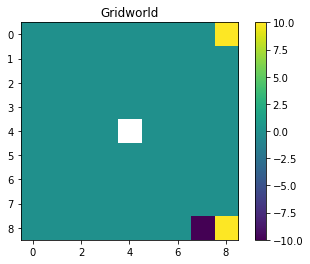

In [5]:
plt.imshow(gridworld, cmap="viridis")
plt.title("Gridworld")
plt.colorbar()

###  Probe of Transition Probabilities 

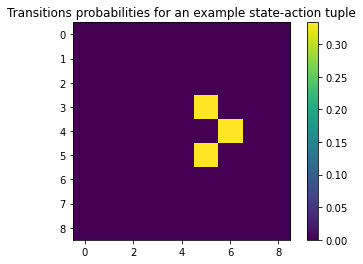

In [6]:
plt.imshow(T[4][5][2][:][:], cmap="viridis")
plt.title("Transitions probabilities for an example state-action tuple")
plt.colorbar()


### Probe of Reward Function

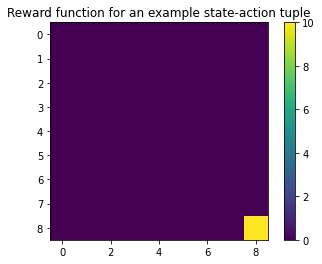

In [7]:
plt.imshow(R[8][7][3][:][:],cmap="viridis")
plt.title("Reward function for an example state-action tuple")
plt.colorbar()

# Linear Program

To solve the LP, the set of constraints must be built in the following functions.

In [8]:
def build_contraints(S,V,R,T,A,gamma):
    constraints = [] 
    
    for idx in range(S.shape[0]):
        for jdx in range(S.shape[1]):
            #get reward of current state
            R_cur = S[idx][jdx]#R[idx][jdx][0][idx][jdx]
            
            if np.isnan(R_cur):
                R_cur=0
            
            #sum up the discounted values of possible actions and target states
            
            #determine possible actions for position, taking into account walls and boundaries 
            possible_actions = [True, True, True, True]
            for adx,action in enumerate(A):
                if not 0<=idx + action[0] < gridworld.shape[0]:
                    possible_actions[adx] = False 
                    continue
                if not 0<=jdx + action[1] < gridworld.shape[1]:
                    possible_actions[adx] = False 
                    continue 
                if np.isnan(gridworld[idx+action[0]][jdx+action[1]]):
                    possible_actions[adx] = False 
                    
            #at this point we have the possible actions 
            # for each action, sum up the discounted value across the target states to
            # calculate the reward constraint
            
            #outer loop is intended action
            for adx,action in enumerate(A):
                
                discounted_value = 0
                
                #intended action is possible
                if possible_actions[adx]:
                    
                    discounted_value+=T[idx][jdx][adx][idx+action[0]][jdx+action[1]]*V[idx+action[0]][jdx+action[1]]
                            
                discounted_value*=gamma
                                                                                                      
                constraints+=[V[idx][jdx] >= R_cur + discounted_value]
            
    return constraints

In [9]:
def value_to_policy(S,V,A,T,R,gamma):
    
    policy = np.zeros(S.shape)
    
    
    #for all states, find the local optimal action
    # and update the V and policy tensors
    for idx in range(S.shape[0]):
        for jdx in range(S.shape[1]):
                
            #initial optimal value and action for state
            V_max = float(-np.inf)
            A_max = 0
                
                
            #iterate over actions
            for adx,action in enumerate(A):
                if idx+action[0] < 0 or idx+action[0] >= S.shape[0]:
                    continue 
                if jdx+action[0] < 0 or jdx+action[1] >= S.shape[1]:
                    continue 
                      
                V_cur = 0
                    
                #iterate over target states accessible via the actions
                # (including unintended states due to transition probabilities)
                for bction in A:
                    if idx+bction[0] < 0 or idx+bction[0] >= S.shape[0]:
                        continue 
                    if jdx+bction[0] < 0 or jdx+bction[1] >= S.shape[1]:
                        continue 
                    V_cur += (T[idx][jdx][adx][idx+bction[0]][jdx + bction[1]])*\
                            (R[idx][jdx][adx][idx+bction[0]][jdx + bction[1]] + \
                             gamma*V[idx+bction[0]][jdx + bction[1]]) 
                       
                #check for optimal value and action
                if V_cur >= V_max:
                    V_max = V_cur
                    A_max = adx
                        
             
            policy[idx][jdx] = A_max
            
    return policy

### LP Solution

In [10]:
# define the optimization variable and the constraints 
V = cvx.Variable(shape=gridworld.shape) #V(s)

constraints = build_contraints(gridworld,V,R,T,A,discount_factor)

obj = cvx.Minimize(cvx.sum(V))
prob = cvx.Problem(obj, constraints)
prob.solve()
print(prob.status)

optimal


In [11]:
policy = value_to_policy(gridworld,V.value,A,T,R,discount_factor)

# Solution

##  Value Map of the Gridworld

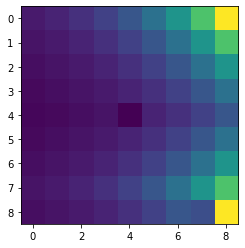

In [12]:
plt.imshow(V.value)

## Policy Map of the Gridworld

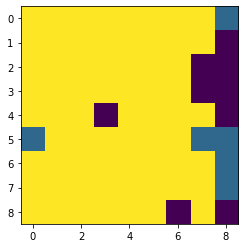

In [13]:
plt.imshow(policy)

 # References: 

[1] https://people.eecs.berkeley.edu/~pabbeel/cs287-fa19/slides/Lec2-mdps-exact-methods.pdf

[2] https://ai.stackexchange.com/questions/11246/how-can-we-use-linear-programming-to-solve-an-mdp

[3] http://www.cs.cmu.edu/afs/cs/academic/class/15780-s16/www/slides/mdps.pdf